In [2]:
import numpy as np
import pandas as pd
import mne
import os
import sys
sys.path.append('../spaces/')
import matplotlib.pyplot as plt
import pubplot as pub
import rsa
import data

pub.styles.set()
C = pub.colours.equidistant('tab20c', k = 20)

In [87]:
'''
data summary
'''

subs = data.Subjects.trim()

print('loss:', len(data.Subjects.select(lambda sub: sub.type != data.subjects.TYPE_PILOT)) - len(subs))
print('sex:', subs.tabulate('sex'), '\nage:', subs.summarise('age'), '\nset:', subs.tabulate('set'))

loss: 1
sex: {'f': 20, 'm': 15} 
age: {'mu': 28.085714285714285, 'sigma': 5.288107566289955, 'min': 20, 'max': 39} 
set: {1: 20, 2: 15}


In [6]:
import rsa

print(rsa.math.unit_tests_2d())

True


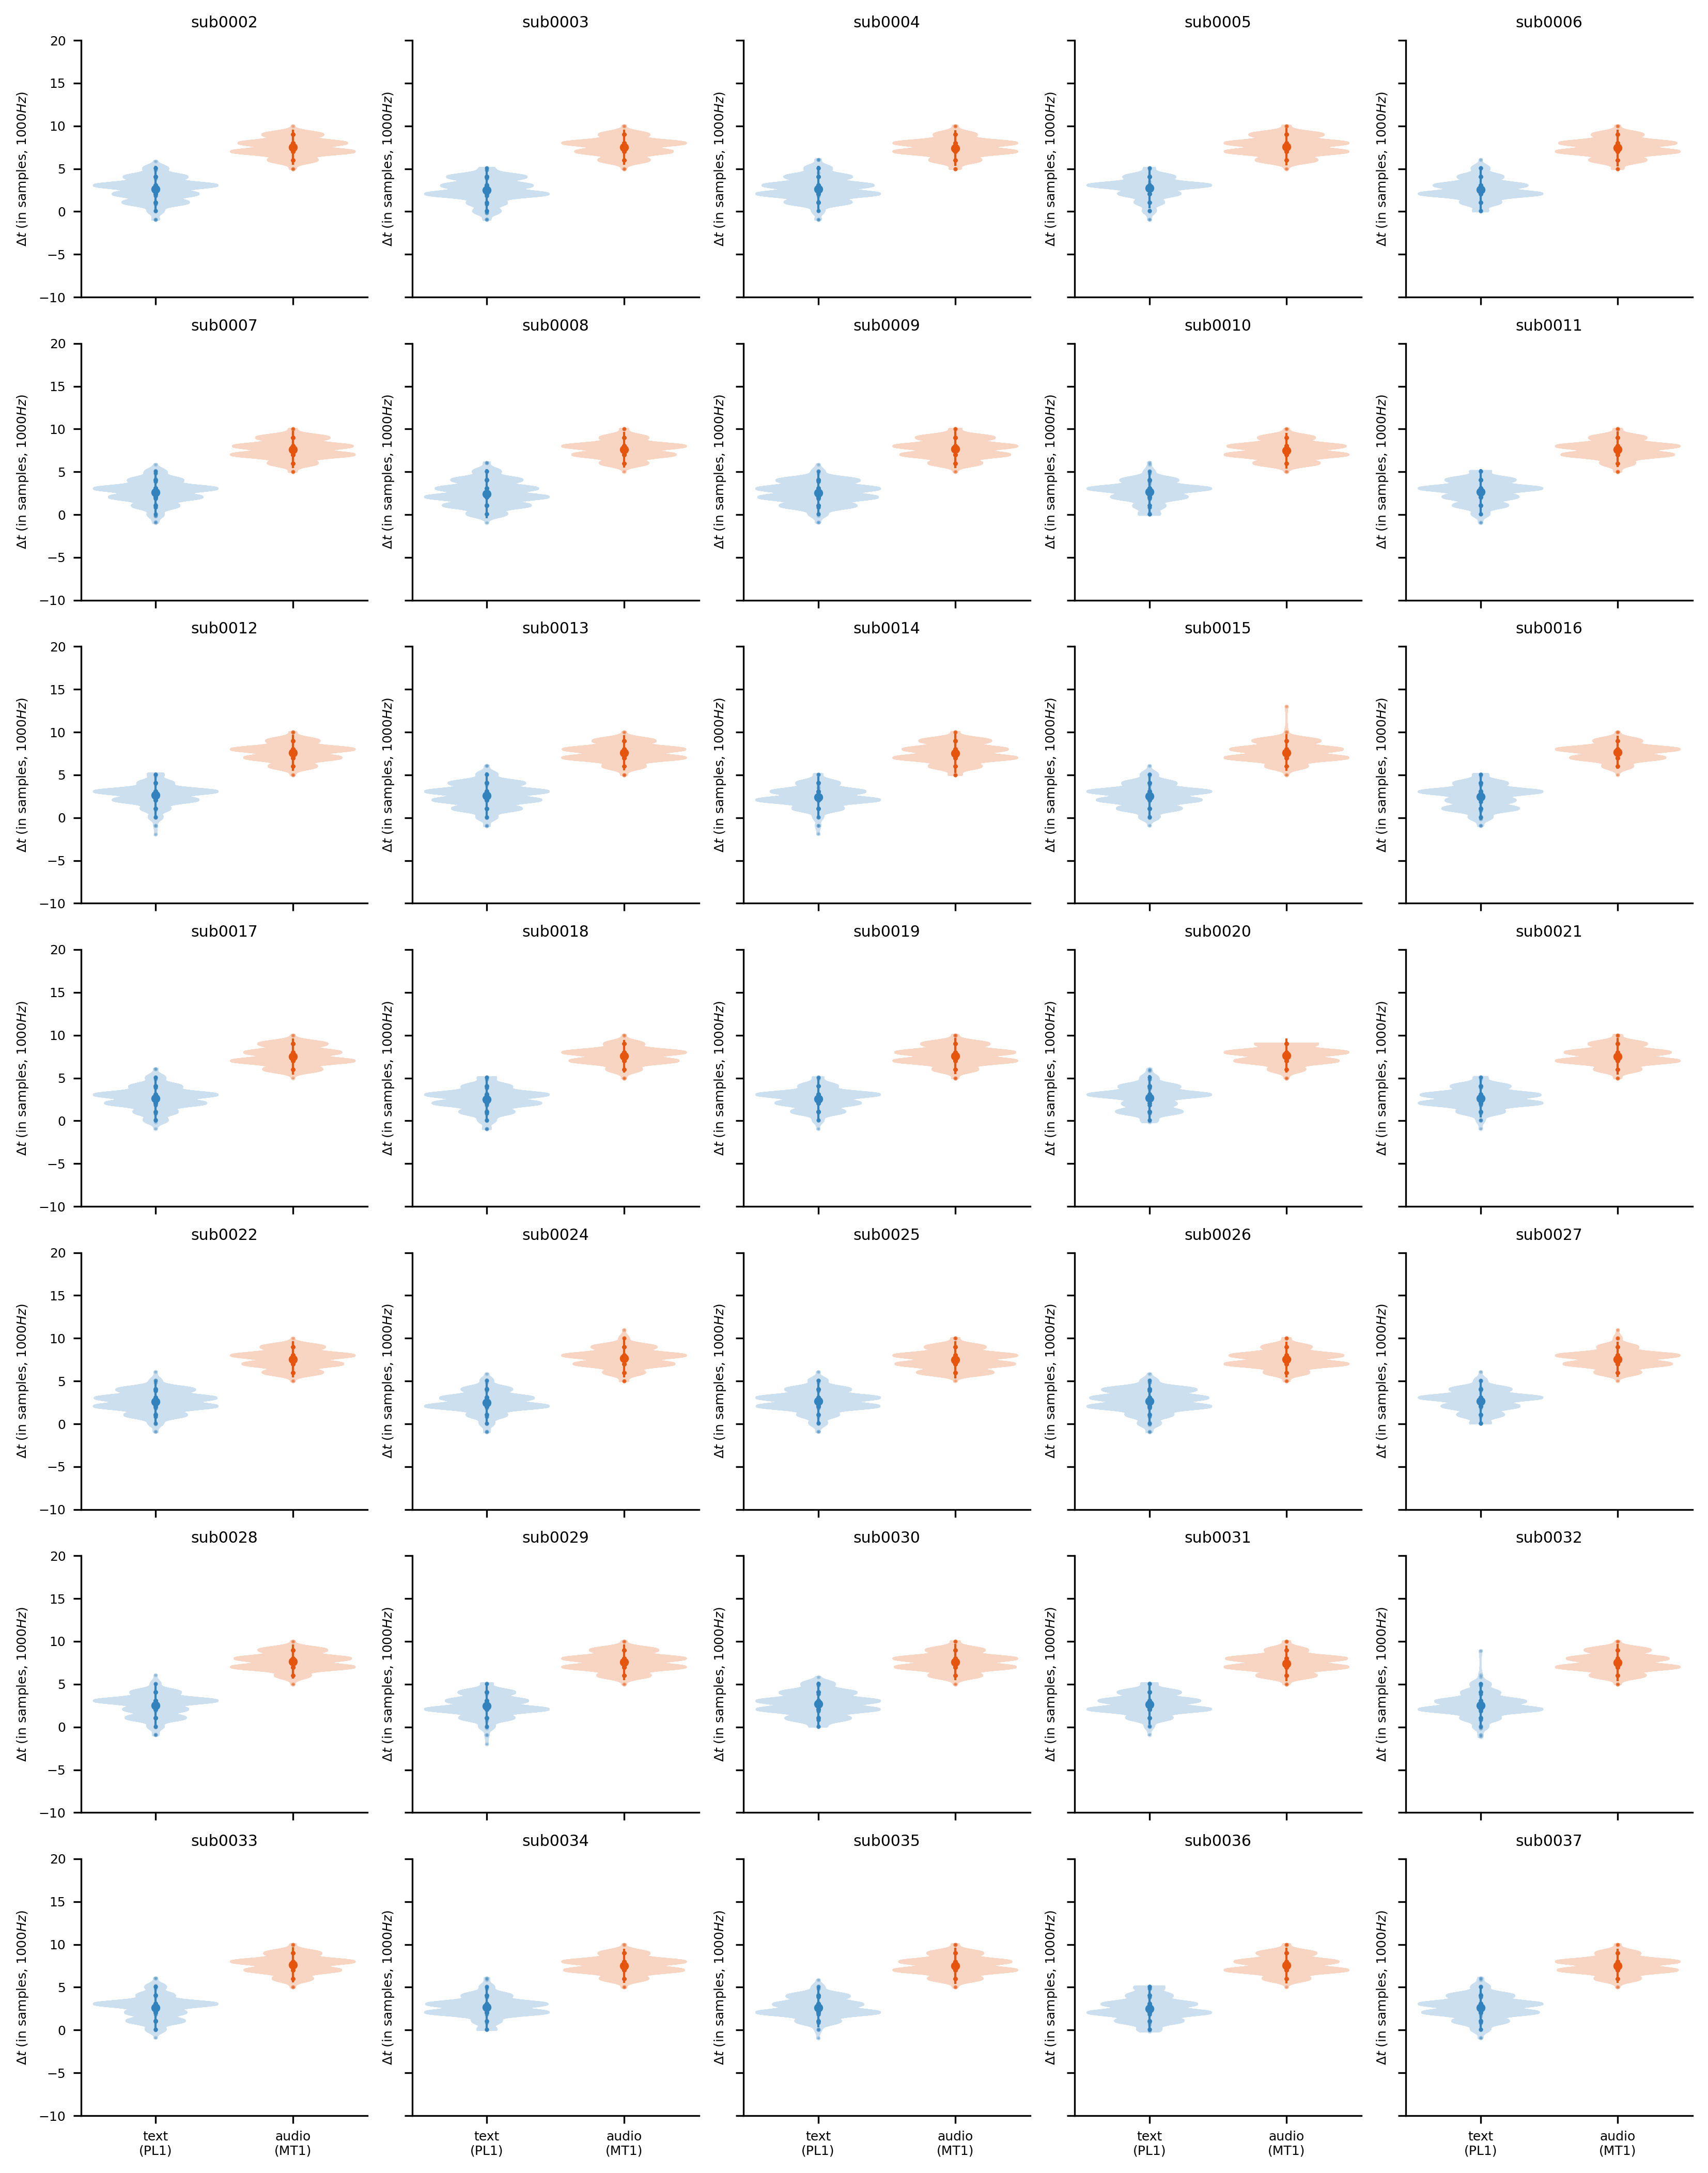

In [97]:
'''
Quality control of EEG and behaviour timing. Effectively,
we are measuring the uncertainty around when exactly events
happened in the registration between time on computer and
time in triggers.
'''

subjects = data.Subjects.trim()

fig, ax = pub.components.figure(nrows = np.ceil(len(subjects) / 5).astype(int), ncols = 5, sharex = True, sharey = True)

for i, sub in enumerate(subjects):
    sid, pid = sub.sid, sub.pid
    j, k = i // 5, i % 5

    # load behaviour & eeg headers
    df = pd.read_csv(f'./data/raw/beh/sub{sid}/{pid}.csv', sep = ',')
    raw = mne.io.read_raw_brainvision(f'./data/raw/eeg/sub{sid}/sempriors{sid}.vhdr', verbose = False)
    triggers, desc = mne.events_from_annotations(raw, verbose = False)

    # find events and compute deltas
    onsets = np.where(triggers[:,2] == 1)[0]
    beh_pl1 = df.loc[df.type == 3].reset_index(drop = True)
    beh_pl2 = df.loc[df.type == 4].reset_index(drop = True)
    beh_mt1 = df.loc[(df.type == 0) | (df.type == 1) | (df.type == 2)].reset_index(drop = True)

    deltas_pl1 = []
    deltas_pl1t = []
    for i in np.arange(0, 252, 1):
        trg = triggers[onsets[i]:onsets[i+1],:]
        d = (trg[1,0] - trg[0,0]) - 550
        deltas_pl1.append(d - (beh_pl1.loc[i].t3 - beh_pl1.loc[i].t2) * 1000)
        
        exp_dur = int(beh_pl1.loc[i].duration*1e3)
        eeg_dur = (trg[2,0] - trg[1,0])
        delta_i = eeg_dur - exp_dur
        deltas_pl1t.append(delta_i - (500 - exp_dur % 500))
    
    deltas_pl2 = []
    for i in np.arange(252, 253, 1):
        trg = triggers[onsets[i]:onsets[i+1],:]
        d = (trg[2,0] - trg[1,0]) - ((5 * 60 + 25) * 1000 + 502)
        deltas_pl2.append(d - (beh_pl2.loc[i-252].t3 - beh_pl2.loc[i-252].t2) * 1000)
    
    deltas_mt1 = []
    deltas_mt1t = []
    deltas_mt1v = []
    for i in np.arange(253, 523, 1):
        trg = triggers[onsets[i]:onsets[i+1],:]
        exp_dur = int(beh_mt1.loc[i-253].duration*1e3)
        eeg_dur = trg[3,0] - trg[2,0] - 400
        deltas_mt1.append(eeg_dur - exp_dur)
        deltas_mt1t.append((beh_mt1.loc[i-253].t4 - beh_mt1.loc[i-253].t3 - 0.4) * 1e3 - exp_dur)
        
        trg = triggers[onsets[i]:onsets[i+1],:]
        d = (trg[2,0] - trg[1,0])
        deltas_mt1v.append(d - 750)#(beh_mt1.loc[i-253].t3 - beh_mt1.loc[i-253].t2) * 1000)
    
    # plot deltas
    pub.dist.violins(np.array([deltas_pl1]), colours = [C[0]], ax = ax[j,k])
    pub.dist.violins(np.array([deltas_mt1]), colours = [C[4]], ax = ax[j,k], offset_x = 1)
    #pub.dist.violins(np.array([deltas_mt1v]), colours = [C[8]], ax = ax[j,k], offset_x = 2)
    ax[j,k].set_title(f'sub{sid}')
    ax[j,k].set_ylabel(r'$\Delta t$ (in samples, $1000Hz$)')
    ax[j,k].set_xticks(np.arange(0, 2, 1))
    ax[j,k].set_xticklabels(['text\n(PL1)', 'audio\n(MT1)'])
    ax[j,k].set_ylim([-10, 20])
    
pub.cosmetics.finish()

In [4]:
'''
Behavioural overview
'''

print('sid\tPL1 (n, p)\tMT1 (rt, p; n, p)\tMT2 (rt, rt)\tMT2(p_g, p_b)')

for sub in data.Subjects.trim():
    df = pd.read_csv(f'./data/raw/beh/sub{sub.sid}/{sub.pid}.csv', sep = ',')
    beh = df.loc[(df.type == data.defs.TRIAL_ET_BAD) | (df.type == data.defs.TRIAL_ET_GOOD)].reset_index(drop = True)
    beh_good = beh.loc[(beh.type == data.defs.TRIAL_ET_GOOD)].reset_index(drop = True)
    beh_bad = beh.loc[(beh.type == data.defs.TRIAL_ET_BAD)].reset_index(drop = True)
    beh_mt1 = df.loc[(df.type == data.defs.TRIAL_MT_MAIN)].reset_index(drop = True)
    beh_mtc = df.loc[(df.type == data.defs.TRIAL_MT_CONTROL)].reset_index(drop = True)
    beh_pl1 = df.loc[(df.type == data.defs.TRIAL_PL1) & (np.isnan(df.rt) == False)].reset_index(drop = True)
    
    rt_good = beh_good.rt.tolist()
    rt_bad = beh_bad.rt.tolist()
    
    p_good = beh_good.correct.tolist()
    p_bad = beh_bad.correct.tolist()
    
    rt_mt = beh_mt1.rt.tolist()
    p_mt = beh_mt1.correct.tolist()
    p_mtc = beh_mtc.correct.tolist()
    
    rt_pl = beh_pl1.rt.tolist()
    p_pl = beh_pl1.correct.tolist()
    
    print(sub.sid, '\t', f'{len(p_pl)}, {np.round(np.nanmean(p_pl), 2)}', '\t', np.round(np.nanmean(rt_mt), 2), np.round(np.nanmean(p_mt), 2), f'({len(p_mtc)}, {np.round(np.nanmean(p_mtc), 2)})', '\t', np.round(np.nanmean(rt_good), 2), np.round(np.nanmean(rt_bad), 2), '\t', np.round(np.mean(p_good), 2), np.round(np.mean(p_bad), 2))

sid	PL1 (n, p)	MT1 (rt, p; n, p)	MT2 (rt, rt)	MT2(p_g, p_b)
0002 	 40, 1.0 	 0.77 0.98 (24, 0.96) 	 0.75 0.96 	 0.9 0.85
0003 	 37, 1.0 	 0.94 0.82 (24, 0.88) 	 0.63 0.71 	 0.82 0.57
0004 	 44, 0.98 	 1.09 0.8 (24, 1.0) 	 1.06 1.29 	 0.88 0.78
0005 	 42, 0.98 	 0.93 0.9 (24, 1.0) 	 0.76 0.96 	 0.87 0.4
0006 	 33, 1.0 	 1.0 0.66 (24, 1.0) 	 0.72 0.78 	 0.93 0.88
0007 	 44, 1.0 	 0.85 0.94 (24, 1.0) 	 0.76 1.26 	 0.9 0.6
0008 	 29, 1.0 	 0.89 0.87 (24, 0.96) 	 0.67 0.73 	 0.95 0.93
0009 	 35, 1.0 	 1.01 0.94 (24, 1.0) 	 0.71 1.05 	 0.92 0.65
0010 	 31, 1.0 	 0.97 0.88 (24, 1.0) 	 0.89 1.13 	 0.8 0.38
0011 	 38, 1.0 	 1.02 0.56 (24, 1.0) 	 0.81 0.94 	 0.92 0.77
0012 	 40, 1.0 	 0.98 0.62 (24, 1.0) 	 0.87 0.89 	 0.83 0.9
0013 	 39, 1.0 	 1.0 0.88 (24, 1.0) 	 0.88 1.14 	 0.87 0.38
0014 	 40, 1.0 	 0.92 0.62 (24, 1.0) 	 0.7 0.7 	 0.98 0.97
0015 	 42, 0.98 	 0.95 0.77 (24, 0.92) 	 0.78 0.86 	 0.95 0.98
0016 	 31, 1.0 	 0.91 0.88 (24, 1.0) 	 0.89 1.17 	 0.9 0.65
0017 	 30, 0.97 	 1.21 0.52 (24

In [20]:
df = pd.read_csv(f'~/downloads/prolific_export_650bf4bbbc0cc503d47efe38.csv')
df = df.loc[(df.Status == 'APPROVED')].reset_index(drop = True)

pid = []
sex = []
age = []

for i in range(len(df)):
    part = df.loc[i]
    pid_i, sex_i, age_i = part['Participant id'], part['Sex'], part['Age']
    
    if pid_i not in pid:
        pid.append(pid_i)
        sex.append(sex_i)
        age.append(int(age_i))

pid = np.array(pid)
sex = np.array(sex)
age = np.array(age)

print('sex')
print(np.unique(sex, return_counts = True))
print('age')
print(age.mean(), age.std(), age.min(), age.max())

sex
(array(['Female', 'Male'], dtype='<U6'), array([17, 18]))
age
29.457142857142856 4.782962961792361 22 39


In [25]:
import glob, os
from scipy.io import wavfile

d = []

for i, path in enumerate(glob.glob(f'./data/raw/audio/clear/*.wav')):
    print(i, end = '\r')
    
    sr, y = wavfile.read(path)
    d.append(y.shape[0] / sr)

d = np.array(d)

print(d.mean(), d.std())

0.9698753171125463 0.1436660531725296


In [27]:
sub = data.Subjects['0002']
sid, pid = sub.sid, sub.pid

df = pd.read_csv(f'./data/raw/beh/sub{sid}/{pid}.csv')
morphs = df.loc[df.type == data.defs.TRIAL_MT_MAIN].duration.tolist()
morphs = np.array(morphs)

print(morphs.mean(), morphs.std())

0.8669250000000001 0.14366311797748887


In [39]:
subjects = data.Subjects.trim()

b_chs = []
b_trl = []

for i, sub in enumerate(subjects):
    sid, pid = sub.sid, sub.pid
    
    bad_chs = np.load(f'./data/preprocessed/eeg/sub{sid}/rsa_bads.npy')
    b_chs.append(len(bad_chs))
    
    _, bad_trls = np.load(f'./data/preprocessed/eeg/sub{sid}/rsa_badtrials.npy', allow_pickle = True)
    b_trl.append(len(bad_trls))
    
b_chs = np.array(b_chs)
b_trl = np.array(b_trl)

print(b_chs.mean(), b_chs.std())
print(b_trl.mean(), b_trl.std())

0.22857142857142856 0.5390846361175202
7.828571428571428 6.4784729871242


In [41]:
subjects = data.Subjects.trim()


b_chs = []
b_trl = []

for i, sub in enumerate(subjects):
    sid, pid = sub.sid, sub.pid
    
    bad_chs = np.load(f'./data/preprocessed/eeg/sub{sid}/rerp_bads.npy')
    b_chs.append(len(bad_chs))
    
    bad_trls = np.load(f'./data/preprocessed/eeg/sub{sid}/rerp_badtrials.npy', allow_pickle = True)
    b_trl.append(len(bad_trls))
    
b_chs = np.array(b_chs)
b_trl = np.array(b_trl)

print(b_chs.mean(), b_chs.std())
print(b_trl.mean(), b_trl.std())

0.0 0.0
4.714285714285714 2.8742345919906955
